In [3]:
import pandas as pd
import re, string
import numpy as np
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\comp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load and preprocess data
df = pd.read_csv(r"C:\Users\comp\Downloads\train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [7]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# Create binary toxicity label
df['toxic_label'] = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].max(axis=1)


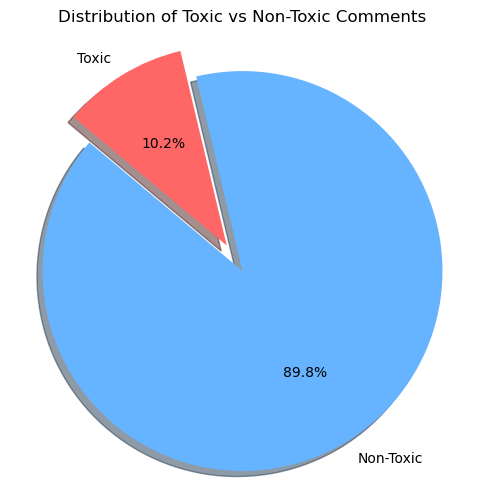

In [9]:
import matplotlib.pyplot as plt

# Count of toxic vs non-toxic comments
toxic_counts = df['toxic_label'].value_counts()
labels = ['Non-Toxic', 'Toxic']
sizes = [toxic_counts[0], toxic_counts[1]]
colors = ['#66b3ff', '#ff6666']
explode = (0.05, 0.1)  # explode a bit to separate the slices visually

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=140, explode=explode, shadow=True)
plt.title('Distribution of Toxic vs Non-Toxic Comments')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


The chart shows that 90% of the comments in the dataset are non-toxic (shown in blue).

Only 10% of the comments are labeled as toxic or inappropriate (highlighted in orange).

The dataset is highly imbalanced, with non-toxic comments making up the vast majority.

Techniques like SMOTE (Synthetic Minority Oversampling Technique) or penalizing misclassification of toxic comments could be considered during training to address the imbalance.



In [10]:
# Stopwords set
stop_words = set(stopwords.words('english'))

In [11]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r"\d+", "", text)
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words).strip()

In [12]:
# Apply preprocessing
df['comment_text'] = df['comment_text'].astype(str).apply(preprocess_text)


In [13]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['toxic_label'], test_size=0.2, random_state=42)


In [14]:
# Convert training text data into TF-IDF features first
tfidf = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [15]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)


In [16]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)


RandomForestClassifier(random_state=42)

In [17]:
# Predict and evaluate
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     28671
           1       0.73      0.69      0.71      3244

    accuracy                           0.94     31915
   macro avg       0.85      0.83      0.84     31915
weighted avg       0.94      0.94      0.94     31915



In [18]:
# Create a full pipeline (so that you can save it as .pkl for app usage)
final_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', clf)
])

In [19]:
# Save the complete pipeline
joblib.dump(final_pipeline, "Toxicity_classifier_v1.pkl")

['Toxicity_classifier_v1.pkl']